In [90]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import tensorflow as tf

import stylegan_two
from stylegan_two import StyleGAN

In [114]:
stylegan_two.im_size = 128
stylegan_two.directory = "frames/"

class OptimisationEncoder:
    def __init__(self, model, batch_size=16) :
        self.model = model
        self.batch_size = batch_size
        self.steps = [(0.1, 200),(0.05, 100),(0.01, 100),(0.005,100)]
        self.loss_hist = []
        self.batch_size = batch_size
        self.n1 = stylegan_two.noiseList(1)
    
    def _opt_step(self, x1,x2, trunc,target,lr):
        with tf.GradientTape(persistent=True) as g:
            result = self.model.GAN.GMA(stylegan_two.n_layers*[x1] + [x2,trunc])
            loss = tf.reduce_sum(tf.abs(result-target))
        dx2 = g.gradient(loss, x2)
        #x1.assign(x1 - lr * dx1)
        x2.assign(x2 - lr * dx2)
        return loss
    
    def _encode_batch(self, paths) :
        n = len(paths)
        n1 = np.repeat(self.n1[0], n, axis=0)
        x1 = tf.Variable(n1)
        n2 = np.random.uniform(0.0, 1.0, size = [n, stylegan_two.im_size, stylegan_two.im_size, 1]).astype('float32')
        x2 = tf.Variable(n2)
        trunc = tf.ones([1, 1]) * 1.0
        target = []
        for path in paths :
            im = Image.open(path)
            im = im.resize((stylegan_two.im_size, stylegan_two.im_size))
            target.append(im)
        target = tf.constant(np.array(im).astype(np.float32)/255)    
        
        hist = []
        for lr,nb in self.steps :
            for i in range(nb) :
                l = self._opt_step(x1,x2,trunc,target,lr)
                hist.append(l.numpy())
                print(lr,hist[-1])
        self.loss_hist.append(hist)
        
        return x2.numpy()
    
    def encode_images(self, paths) :
        i = 0
        res = []
        while i < len(paths) :
            next_i = min(len(paths), i+self.batch_size)
            res.append(self._encode_batch(paths[i:next_i]))
            i = next_i
            print(next_i/len(paths))
        return np.concatenate(res)
    
    def transform(self, lattents) :
        images = []
        trunc = np.ones([1, 1]) * 1.0
        for lattent in lattents :
            n2 = tf.expand_dims(lattent, 0)
            images.append(self.model.GAN.GMA(self.n1 + [n2])[0].numpy())
        return images

In [92]:
model = StyleGAN(lr = 0.0001, silent = False)
model.load(8)

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_273 (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
lambda_133 (Lambda)             (None, 1)            0           input_273[0][0]                  
__________________________________________________________________________________________________
dense_257 (Dense)               (None, 1536)         3072        lambda_133[0][0]                 
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 4, 4, 96)     0           dense_257[0][0]                  
___________________________________________________________________________________________

In [93]:
paths = glob.glob('frames/*.jpg')
encoder = OptimisationEncoder(model)

In [94]:
res = encoder.encode_images(paths)


0.1 28282.809
0.1 27004.316
0.1 26121.488
0.1 25461.68
0.1 25028.266
0.1 24675.988
0.1 24332.447
0.1 23971.559
0.1 23737.816
0.1 23554.73
0.1 23516.81
0.1 23150.107
0.1 22583.477
0.1 22364.29
0.1 22150.887
0.1 21611.127
0.1 21132.1
0.1 20697.37
0.1 20351.145
0.1 19946.9
0.1 19487.969
0.1 19136.94
0.1 18796.393
0.1 18479.494
0.1 18117.668
0.1 17919.023
0.1 18011.82
0.1 17475.701
0.1 17361.084
0.1 17250.854
0.1 16792.184
0.1 16614.643
0.1 16773.309
0.1 16943.262
0.1 16523.258
0.1 16388.945
0.1 16230.078
0.1 16126.947
0.1 16192.403
0.1 16097.208
0.1 15871.619
0.1 15987.846
0.1 15856.755
0.1 15816.662
0.1 15561.821
0.1 15320.346
0.1 15326.113
0.1 15398.008
0.1 15493.49
0.1 15512.787
0.1 15295.758
0.1 15201.047
0.1 15307.319
0.1 15004.904
0.1 14874.557
0.1 14881.316
0.1 14950.102
0.1 14884.631
0.1 14727.165
0.1 14566.043
0.1 14660.023
0.1 14624.937
0.1 14548.252
0.1 14485.156
0.1 14625.347
0.1 14638.566
0.1 14530.055
0.1 14481.387
0.1 14174.615
0.1 14218.3545
0.1 14560.736
0.1 14708.11
0.1

In [95]:
images = encoder.transform(res)

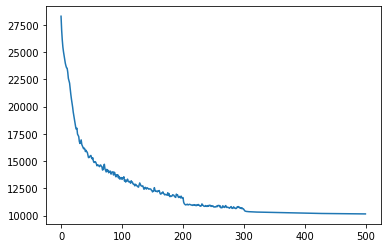

In [96]:
plt.plot(encoder.loss_hist[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


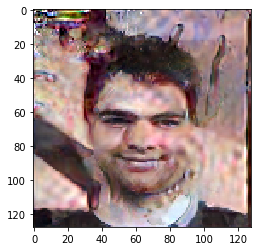

In [104]:
plt.imshow(images[1])

In [123]:
save_paths = [s.replace("frames", "decoded_frames") for s in paths]

In [127]:
for path, image in zip (save_paths, images) :
    im = Image.fromarray((np.clip(images[0].numpy(), 0, 1)*255).astype(np.uint8))
    im.save(path)